In [1]:
%matplotlib inline
import numpy as np
import scipy
from scipy.signal import hilbert, chirp, spectrogram, periodogram
import matplotlib.pyplot as plt
from hwpy.common.cordic import CORDIC

fs = 1e3
periods = 1
data_freq = 20

# FM modulator

### Data signal

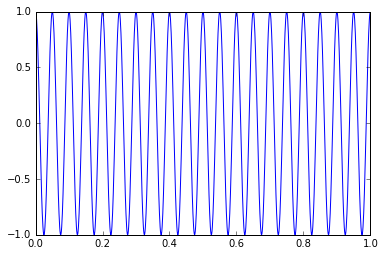

In [2]:
time = np.linspace(0, periods, fs*periods, endpoint=False) # NB! NOTICE ENDPOINT TO MATCH GNURADIO

data = np.cos(2*np.pi*data_freq*time)
plt.plot(time,data)

### Modulated signal

Sensitivity: 2.0943951023931953


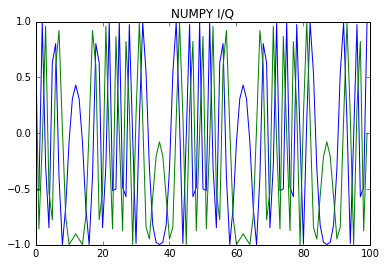

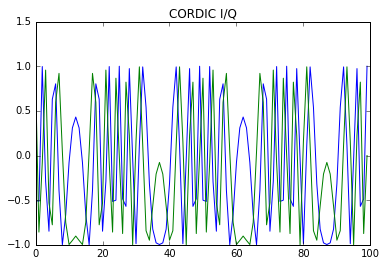

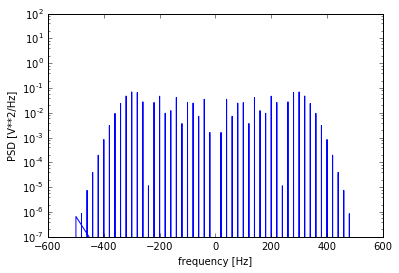

In [3]:
deviation = fs/3
sensitivity = 2*np.pi*deviation/fs
print('Sensitivity:', sensitivity)

d_phase = 0
phl = []

phl = np.cumsum(sensitivity*data)

ref = np.exp(phl*1j)

cord = CORDIC(32)
mod = cord.exp(phl*1j)

plt.plot(ref.real[:100])
plt.plot(ref.imag[:100])
plt.title('NUMPY I/Q')
plt.show()

plt.plot([x.real for x in mod[:100]])
plt.plot([x.imag for x in mod[:100]])
plt.title('CORDIC I/Q')
plt.show()

f, Pxx_den = periodogram(mod, fs)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

### Compare

In [4]:
# reference GNURADIO samples
gr_fmmod = scipy.fromfile(open('mod_samples.32fc'), dtype=scipy.complex64)
np.testing.assert_almost_equal(gr_fmmod[:len(ref)], ref, decimal=4)

np.testing.assert_almost_equal(ref, mod, decimal=6)

CORDIC implementation is equal to NUMPY implemetation, which itself is equal to GNURADIO samples.
All good.

# FM demodulator

Demodulator gain:  0.477464829275686


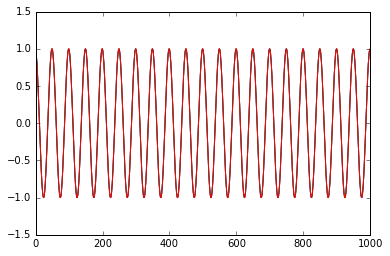

In [5]:
gain = fs/(2*np.pi*deviation)
print('Demodulator gain: ', gain)

baseband = mod
ref_demod_data = gain * np.angle( baseband[1:] * np.conjugate(baseband[:-1]) )

cord_demod_data = gain * np.array(cord.angle( baseband[1:] * np.conjugate(baseband[:-1]) ))
plt.plot(ref_demod_data)
plt.plot(cord_demod_data)
plt.plot(data[1:])

## Compare

In [6]:
np.testing.assert_almost_equal(ref_demod_data, cord_demod_data)
np.testing.assert_almost_equal(data[1:], cord_demod_data, decimal=5)

Initial data is recovered. First sample is lost, becuse we need diff in demodulator.